## Feature Development Extraction: Neurophysiology [dyskinesia project]




<b> Content </b>


<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)
- aperiodic component, PD severity, and cortico-subcortico-activity, Bush & Zou, Richardson, bioRxiv 2023 https://www.biorxiv.org/content/10.1101/2023.02.08.527719v1?rss=1

<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition





### 0. Loading packages and functions, defining paths



In [ ]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
from scipy.stats import pearsonr, mannwhitneyu

import matplotlib.pyplot as plt

from scipy import signal, stats
from array import array
import datetime as dt
# #mne
# import mne_bids
import mne


In [ ]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
# print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

In [ ]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [ ]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')

In [ ]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_plotting.expl_plotting as expl_plot
import lfpecog_features.feats_spectral_baseline as specBase
import lfpecog_features.feats_spectral_features as spectral
import lfpecog_features.feats_spectral_helpers as specHelp
import lfpecog_features.feats_helper_funcs as ftHelp

import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults
# import lfpecog_analysis.get_acc_derivs as accDerivs


import lfpecog_plotting.plotHelpers as plotHelp

In [ ]:
colors = list(plotHelp.get_colors().values())

Check and Plot CDRS scores from both raters

In [ ]:
import traces
import datetime as dt

In [ ]:
max_scores_bilat = []
max_scores_ecoglat = []
rater='Patricia'

for s in ['008', '009', '010', '012',
             '013', '014', '016', '017']:

    t, scores = importClin.get_cdrs_specific(
        sub=s, rater=rater, side='both')
    max_scores_bilat.append(np.nanmax(scores))

    t, scores = importClin.get_cdrs_specific(
        sub=s, rater=rater, side='contra ecog')
    max_scores_ecoglat.append(np.nanmax(scores))

print('BILATERAL', max_scores_bilat, np.mean(max_scores_bilat))
print('ECoG lat.', max_scores_ecoglat, np.mean(max_scores_ecoglat))

In [ ]:
importlib.reload(importClin)
# CHECK CLINICAL RATINGS
subs_incl = ['008', '009', '010', '012',
             '013', '014', '016']

clrs = colors
styles = ['solid', 'dotted']
fig, axes = plt.subplots(1,1, figsize=(12, 6))

for i_sub, sub in enumerate(subs_incl):
    reg_t, reg_scores = {}, {}
    for i_r, rater in enumerate(['Patricia', 'Jeroen']):
        t, scores = importClin.get_cdrs_specific(sub=sub, rater=rater)
        axes.plot(t, scores,  # [0]
                color=clrs[i_sub], ls=styles[i_r], lw=3, label=f'{sub} ({rater})')

        # regularize scores
        reg_t[i_r], reg_scores[i_r] = importClin.get_cdrs_specific(
            sub=sub, rater=rater, regularize=True,)
        # axes[1].plot(reg_t[i_r], reg_scores[i_r],
        #         color=clrs[i_sub], ls=styles[i_r], lw=3, )
    
    # calculate correlations
    # only take minutes present in both scores
    t_start = max([reg_t[i_r][0] for i_r in [0, 1]])
    t_stop = min([reg_t[i_r][-1] for i_r in [0, 1]])
    sel0 = [time >= t_start and time <= t_stop for time in reg_t[0]]
    sel1 = [time >= t_start and time <= t_stop for time in reg_t[1]]
    
    print(sub, pearsonr(reg_scores[0][sel0], reg_scores[1][sel1]))

# axes[0].set_title('Inserted scores per timepoint', size=14)
# axes[1].set_title('Interpolated scores (per 1 minute)', size=14)
handles, labels = axes.get_legend_handles_labels()
plt.legend(handles, labels, ncol=5, bbox_to_anchor=(.5, -.25),
               loc='upper center', fontsize=14,)
# for ax in axes:
axes.set_ylabel('CDRS score', fontsize=14)
axes.set_xlabel('Time (minutes vs LDOPA-intake)', fontsize=14)
axes.tick_params(axis='both', labelsize=14, size=14)

plt.tight_layout()
# figname = 'CDRS_scores_2rater_interpolation'
# plt.savefig(os.path.join(figpath, 'clinical_scores', figname), dpi=150,
#             facecolor='w',)
# figname = 'CDRS_scores_2raters'
# plt.savefig(os.path.join(figpath, 'clinical_scores', figname), dpi=150,
#             facecolor='w',)
plt.close()




### 1. Load Merged Sub-Data

#### load none ephys pickle

In [ ]:
subs_to_plot = [
    '008', '009', '010', '012', 
    '013', '014', '016']

data_version = 'v3.1'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    acc = load_class_pickle(os.path.join(
        get_project_path('data'),
        'merged_sub_data', data_version,
        f'{sub}_mergedDataClass_{data_version}_noEphys.P'
    ))
    acc = correct_acc_class(acc)

    mins_recording.append(acc.data.shape[0] / acc.fs / 60)

#### load ephys pickle

WINDOWED DATA

In [ ]:
subs_to_plot = [
    # '008', '009', '010', '012', 
    # '013', '014',
    '012',
]
task = 'rest'
data_version = 'v3.0'
mins_recording = []

# for sub in subs_to_plot:
#     # load Acc-detected movement labels
#     data = load_class_pickle(os.path.join(
#         get_project_path('data'), 'windowed_data_classes_60s',
#         data_version, f'sub-{sub}', task,
#         f'{sub}_mneEpochs_{task}_{data_version}_win60s_overlap0.5.P'
#     ))
#     # acc = correct_acc_class(acc)


In [ ]:
data.list_mne_objects[0].times.shape

data.list_mne_objects[0].ch_names

data.list_mne_objects[0].get_data().shape

MERGED DATA per DATATYPE (source)


In [ ]:
subs_incl = [
    '013', 
    # '009', '010', '012', 
    # '013', '014',
    # '012',
]
# task = 'rest'
data_version = 'v3.0'

# for sub in subs_incl:
#     # load merged data class
#     data = load_class_pickle(os.path.join(
#         get_project_path('data'), 'merged_sub_data',
#         data_version,
#         f'{sub}_mergedDataClass_{data_version}.P'
#     ))

In [ ]:
sub = '012'
dat = {}
dType = 'lfp_left'
dat[dType] = load_class_pickle(os.path.join(
        get_project_path('data'), 'merged_sub_data',
        data_version, f'sub-{sub}',
        f'{sub}_mergedData_{data_version}_{dType}.P'
    ))

Load windows

In [ ]:
ephys_sources = ['lfp_left', ]  #'lfp_right', 'ecog_left', 'ecog_right']
use_stored_windows = True

sub = '014'
json_path = os.path.join(utilsFiles.get_onedrive_path('data'),
                     'featureExtraction_jsons',
                     'ftExtr_spectral_v1.json')
with open(json_path, 'r') as json_data:
    SETTINGS = json.load(json_data)

windows_path = os.path.join(utilsFiles.get_project_path('data'),
                    'windowed_data_classes_'
                    f'{SETTINGS["WIN_LEN_sec"]}s_'
                    f'{SETTINGS["WIN_OVERLAP_part"]}overlap',
                    SETTINGS['DATA_VERSION'],
                    f'sub-{sub}')

In [ ]:
for dType in ephys_sources:
    print(f'\tstart {dType}')
    # define path for windows of dType
    dType_fname = (f'sub-{sub}_windows_'
                    f'{SETTINGS["WIN_LEN_sec"]}s_'
                    f'{SETTINGS["DATA_VERSION"]}_{dType}.P')
    dType_win_path = os.path.join(windows_path, dType_fname)
    
    # check if windows are already available
    if np.logical_and(use_stored_windows,
                        os.path.exists(dType_win_path)):
        print(f'load data from {windows_path}....')
        windows = utilsFiles.load_class_pickle(dType_win_path)
        print(f'\tWINDOWS LOADED from {dType_fname} in {windows_path}')

In [ ]:
# filter out none-ephys signals
sel_chs = [c.startswith('LFP') or c.startswith('ECOG')
            for c in windows.keys]
print(f'GOT WINDOWS {dType}, shape: {windows.data.shape}, '
        f'colnames: {windows.keys}')
setattr(windows, 'data', windows.data[:, :, sel_chs])
setattr(windows, 'keys', list(compress(windows.keys, sel_chs)))
print(f'\tWINDOWS {dType} ONLY EPHYS, shape: {windows.data.shape}, '
        f'colnames: {windows.keys}')

### Plot ssd'd Spectral Descriptives

In [ ]:
import lfpecog_features.get_ssd_data as ssd
import lfpecog_analysis.ft_processing_helpers as ftProc
import lfpecog_analysis.get_SSD_timefreqs as ssd_TimeFreq

In [ ]:
### PLOT VISUAL SSD OVERVIEW

# # loop over defined frequency bands
# for bw in SETTINGS['SPECTRAL_BANDS']:
#     f_range = SETTINGS['SPECTRAL_BANDS'][bw]
    # check whether to perform SSD
    # (ssd_filt_data,
    #     ssd_pattern,
    #     ssd_eigvals
    # ) = ssd.get_SSD_component(
    #     data_2d=win_dat.T,
    #     fband_interest=f_range,
    #     s_rate=windows.fs,
    #     use_freqBand_filtered=True,
    #     return_comp_n=0,
    # )

#     f, psd = signal.welch(ssd_filt_data, axis=-1,
#                     nperseg=windows.fs, fs=windows.fs)
#     plt.plot(f, psd, label=bw)

        

# plt.xlim(0, 100)
# plt.title(f'WINDOW # {i_w} - {dType.upper()}')
# plt.legend()
# plt.show()

#### SSD time freq plotting


In [ ]:
# get windowed bands of different dtypes per sub
importlib.reload(ftHelp)
importlib.reload(ssd)
importlib.reload(ssd_TimeFreq)

sub = '016'

# call from feats_extract_multivar.py
ssd_subClass = ssd.get_subject_SSDs(
    sub=sub,
    incl_stn=True,
    incl_ecog=True,
    ft_setting_fname='ftExtr_spectral_v4.json',)




In [ ]:
def get_timeFreq_xticks(x_times):
    """
    Input:
        - xticks given in seconds
    
    Returns:
        - xticks
        - xticklabels (in minutes)
    """
    # define first and last tick rounded on 10 minutes
    first_xtick = np.ceil((x_times / 60 / 10)[0]) * 10
    last_xtick = np.floor((x_times / 60 / 10)[-1]) * 10
    # get ticklabels in 10 minute spacing
    xticklabels = np.arange(first_xtick, last_xtick+1, 10).astype(int)
    # find nearest indices in x_times for created labels
    xticks = np.array([np.argmin(abs(x_times/60 - t)) for t in xticklabels])
    # drop ticks and labels if they are too close (visually overwrite each other)
    drop_close_ticks = np.append(np.array([False]), np.diff(xticks) < 150)
    # drop too close ticks, labels
    xticklabels = xticklabels[~drop_close_ticks]
    xticks = xticks[~drop_close_ticks]

    return xticks, xticklabels

In [ ]:

source = 'ecog_right'
fig_name = f'ssdTimeFreq_sub{sub}_{source}_CDRSscore'
LOG_POWER = False
BASELINE_CORRECT = False
PERC_CHANGE = False
ZSCORE = True
SAVE_PLOT = False

if LOG_POWER: fig_name += '_logPow'
if BASELINE_CORRECT: fig_name += '_blCorr'
if PERC_CHANGE: fig_name += 'PerCh'

# ssd_subClass = ssd.get_subject_SSDs(
#     sub=sub,
#     incl_stn=True,
#     incl_ecog=True,
#     ft_setting_fname='ftExtr_spectral_v4.json',)

subSourceSSD = getattr(ssd_subClass, source)


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fsize=16
if LOG_POWER:
    if BASELINE_CORRECT:
        if 'lfp' in source:
            vmin, vmax = -5, 5
        elif 'ecog' in source:
            vmin, vmax = -2.5, 2.5
        if PERC_CHANGE:
            vmin, vmax = -10, 10
        cmap = 'PuOr_r'
    else:
        vmin, vmax = -10, 0
        cmap = 'plasma'

elif ZSCORE:
    vmin, vmax = -2, 2
    cmap = 'PuOr_r'

else:
    if BASELINE_CORRECT:
        vmin, vmax = -.2, .2
        cmap = 'PuOr_r'
        if PERC_CHANGE:
            vmin, vmax = -10, 10
    else:
        vmin, vmax = 0, .2
        cmap = 'viridis'

# get combined time freq array from SSD timeseries
(timefreqArr, tf_times,
 min_f, max_f) = ssd_TimeFreq.create_SSD_timeFreqArray(subSourceSSD)
tf_values = timefreqArr.values

if ZSCORE:
    for row_i, row_data in enumerate(tf_values):
        tf_values[row_i] = (tf_values[row_i] - np.nanmean(tf_values[row_i])
                            ) / np.nanstd(tf_values[row_i])

if BASELINE_CORRECT:
    tf_values = ssd_TimeFreq.correct_timeFreq_baseline(
        tf_values, tf_times, perc_change=PERC_CHANGE
    )
if LOG_POWER: tf_values = np.log10(tf_values)

# get nearest CDRS values for ephys-timings
_, ephys_cdrs = ftProc.find_select_nearest_CDRS_for_ephys(
    sub=subSourceSSD.sub,
    ft_times=tf_times / 60,
    LATERALITY='BILAT',
    cdrs_rater='Patricia',
)
# convert CDRS labels into categories
cat_cdrs = ftProc.categorical_CDRS(
    y_full_scale=ephys_cdrs,
    time_minutes=tf_times / 60,
    preLID_minutes=10,
    preLID_separate=True,
    convert_inBetween_zeros='mild',
)

# plot time freq plot
im = ax.pcolormesh(tf_values, cmap=cmap,
                    vmin=vmin, vmax=vmax
)
cbar = fig.colorbar(im, ax=ax, pad=0.1)

# set yticks with 16 Hz jumps
ax.set_yticks(np.arange(0, tf_values.shape[0], 16))
ax.set_yticklabels(np.arange(min_f, max_f, 16))
# get first and last xticks rounded on 10 minutes
xticks, xticklabels = get_timeFreq_xticks(tf_times)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
# create labels
ax.set_xlabel('Time (minutes vs L-Dopa intake)', fontsize=fsize)
ax.set_ylabel('Frequency (Hz)', fontsize=fsize)

cbar.ax.tick_params(labelsize=fsize)
cbar_label = 'Spectral Power (a.u.)'
if LOG_POWER: cbar_label = 'Log ' + cbar_label
if ZSCORE: cbar_label = 'Z-scored  ' + cbar_label
if BASELINE_CORRECT: cbar_label = 'Baseline corr. ' + cbar_label
if PERC_CHANGE: cbar_label = cbar_label[:-6] + "(%-change)"
cbar.ax.set_ylabel(cbar_label, fontsize=fsize)
ax.tick_params(size=fsize, labelsize=fsize, axis='both')

ax.set_title(f'SSD-timefreq. subject: {sub}, {source}', fontsize=fsize)


# PLOT CDRS
ax_cdrs = ax.twinx()

if cmap in ['viridis', 'plasma']: cdrs_col = 'lightgray'
elif cmap in ['PuOr', 'PuOr_r']: cdrs_col = 'darkgreen'
# ax_cdrs.plot(cat_cdrs, color='gray', lw=3,)
# ax_cdrs.set_ylabel('CDRS categories')

ax_cdrs.plot(ephys_cdrs, color=cdrs_col, lw=5, alpha=.5)
ax_cdrs.set_ylabel('CDRS scores', size=fsize)

ax_cdrs.tick_params(size=fsize, labelsize=fsize)

plt.tight_layout()

# plt.savefig(os.path.join(figpath, 'ft_exploration', 'v4.0', 'ssd_timeFreqs', fig_name),
#             facecolor='w', dpi=300,)

plt.show()

#### SSD PSD plotting

In [ ]:
import lfpecog_plotting.plot_descriptive_SSD_PSDs as plot_PSDs

In [ ]:
WIN_LEN=10
WIN_OVERLAP=0.5
DATA_VERSION='v4.0'
FT_VERSION='v4'
SSD_BROAD=True
INCL_STN_ONLY_PTS=True
IGNORE_PTS=['011',]

In [ ]:
# get all available subs with features

ssd_folder = 'SSD_feats'
if SSD_BROAD: ssd_folder += '_broad'
ssd_path = os.path.join(get_project_path('results'), 'features',
                        ssd_folder, DATA_VERSION,
                        f'windows_{WIN_LEN}s_'
                        f'{WIN_OVERLAP}overlap')
SUBS = list(set([name.split('_')[1] for name in os.listdir(ssd_path)]))

# remove ignore patients and e.g. STN onlys
remove_subs = []
if not INCL_STN_ONLY_PTS:
    for sub in SUBS:
        if sub.startswith('1'): remove_subs.append(sub)

for sub in IGNORE_PTS + remove_subs:
    if sub in SUBS: SUBS.remove(sub)

print(SUBS)


In [444]:
importlib.reload(ssd_TimeFreq)


TFs = ssd_TimeFreq.get_all_ssd_timeFreqs(SUBS=SUBS)


...loaded subject-101 Time-Frequency data
...loaded subject-103 Time-Frequency data
...loaded subject-102 Time-Frequency data
...loaded subject-014 Time-Frequency data
...loaded subject-012 Time-Frequency data
...loaded subject-010 Time-Frequency data
...loaded subject-016 Time-Frequency data
...loaded subject-008 Time-Frequency data
...loaded subject-017 Time-Frequency data
...loaded subject-009 Time-Frequency data
...loaded subject-013 Time-Frequency data


Plot single subject-source data


In [ ]:

importlib.reload(ftProc)

LOG_POWER = True
CATEG_CDRS = True
source = 'lfp_right'


tf_temp = TFs['013']['lfp_right']
tf_values = tf_temp.values
tf_times = tf_temp.times
tf_freqs = tf_temp.freqs

if LOG_POWER:
    tf_values = np.log10(tf_values)

# get nearest CDRS values for ephys-timings
_, ephys_cdrs = ftProc.find_select_nearest_CDRS_for_ephys(
    sub=subSourceSSD.sub,
    ft_times=tf_times / 60,
    side='BILAT',
    cdrs_rater='Jeroen',
)
ephys_cdrs = np.around(ephys_cdrs.astype(np.float64), 0)

# convert CDRS labels into categories
if CATEG_CDRS:
    ephys_cdrs, cdrs_cats = ftProc.categorical_CDRS(
        y_full_scale=ephys_cdrs,
        time_minutes=tf_times / 60,
        preLID_minutes=10,
        preLID_separate=True,
        convert_inBetween_zeros='none',
        return_coding_dict=True
    )

In [ ]:
# '016' : check why short peak of CDRS 3 at beginning of LID?

Plot Group Results: non-LID / LID versus Dopa-Time

In [440]:
importlib.reload(plot_PSDs)

SAVE=True
SHOW=False
fig_name = f'STN_PSDs_noLID_LID_vs_DopaTime_n{len(SUBS)}'


# make groups with and without occurence of LID
subs_LID = []
subs_noLID = []

for sub in SUBS:
    max_score = max(ftProc.get_cdrs_specific(sub=sub,
                                             rater='Jeroen',
                                             side='both')[1])
    if max_score > 0: subs_LID.append(sub)
    else: subs_noLID.append(sub)


# plot_PSD_vs_DopaTime(TFs['008']['lfp_left'])
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fsize=20
SMOOTH_FREQS=8
LOG_POWER=False
BASELINE_CORRECT=True


axes[0] = plot_PSDs.plot_PSD_vs_DopaTime(
    TFs, sel_subs=subs_noLID,
    BASELINE_CORRECT=BASELINE_CORRECT,
    LOG_POWER=LOG_POWER, SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    plt_ax_to_return=axes[0], fsize=fsize, BREAK_X_AX=True,
)
axes[0].set_title(f'Subjects WITHOUT Dyskinesia (n={len(subs_noLID)})',
                  size=fsize, weight='bold',)

axes[1] = plot_PSDs.plot_PSD_vs_DopaTime(
    TFs, sel_subs=subs_LID,
    LOG_POWER=LOG_POWER, SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    BASELINE_CORRECT=BASELINE_CORRECT,
    plt_ax_to_return=axes[1], fsize=fsize, BREAK_X_AX=True,
)
axes[1].set_title(f'Subjects WITH Dyskinesia (n={len(subs_LID)})',
                  size=fsize, weight='bold',)


# equalize axes
ymin = min([min(ax.get_ylim()) for ax in axes])
ymax = max([max(ax.get_ylim()) for ax in axes])
for ax in axes: ax.set_ylim(ymin, ymax)

for ax in axes: ax.tick_params(axis='both', size=fsize,
                               labelsize=fsize)
plt.tight_layout()

if SAVE:
    plt.savefig(os.path.join(get_project_path('figures'), 'ft_exploration',
                         DATA_VERSION, 'descr_PSDs', fig_name),
                facecolor='w', dpi=300,)
if SHOW: plt.show()
else: plt.close()



Plot LID-Group Results: Laterality of LID in STN and ECoG

In [457]:
from lfpecog_plotting.plotHelpers import get_colors

In [482]:
def plot_PSD_vs_LID_laterality(
    all_timefreqs, sel_subs=None,
    LOG_POWER=True, ZSCORE_FREQS=True,
    SMOOTH_PLOT_FREQS=0,
    #BASELINE_CORRECT=False,
    BREAK_X_AX=False, plt_ax_to_return=False,
    fsize=12,
):
    """
    Plot group-level PSDs (based on SSD data), plot
    mean unilateral PSDs versus unilateral CDRS.

    Input:
        - all_timefreqs: (results from ssd_TimeFreq.get_all_ssd_timeFreqs)
            contains tf_values (shape n-freq x n-times), times, freqs.
        - sel_subs: if given, selection of subjects to include
        - LOG_POWER: plot powers logarithmic
        - ZSCORE_FREQS: plot PSDs as z-Scores per freq-bin
        - SMOOTH_PLOT_FREQS: if > 0, window (n freqs) to
            smoothen PSDs values
        - BASELINE_CORRECT: plot difference of time-windows
            versus pre-Dopa-intake
        - BREAK_X_AX: break x-axis between beta and gamma
        - plt_ax_to_return: if plotted as subplot in another plot,
            give the defined axis here
        - fsize: fontsize, defaults to 12
    """
    psds_to_plot = {'match': [], 'nonmatch': []}

    if sel_subs:
        subs = [sub for sub in all_timefreqs.keys()
                if sub in sel_subs]
    else:
        subs = all_timefreqs.keys()

    for sub in subs:
        
        for src in all_timefreqs[sub].keys():

            if 'ecog' in src: continue
            # get data for this sub and ephys-source
            tf_values = all_timefreqs[sub][src].values

            if LOG_POWER: tf_values = np.log(tf_values)
            if ZSCORE_FREQS:
                for f in np.arange(tf_values.shape[0]):
                    tf_values[f] = (
                        tf_values[f] - np.mean(tf_values[f])
                    ) / np.std(tf_values[f])

            tf_times = all_timefreqs[sub][src].times / 60
            tf_freqs = all_timefreqs[sub][src].freqs

            if 'left' in src:
                match_bodyside = 'right'
                nonmatch_bodyside = 'left'
            elif 'right' in src:
                match_bodyside = 'left'
                nonmatch_bodyside = 'right'

            sub_cdrs = {'match': {}, 'nonmatch': {}}  # CDRS scores related to BODYSIDE

            # get nearest CDRS values for psd-timings
            _, sub_cdrs['match'] = ftProc.find_select_nearest_CDRS_for_ephys(
                sub=sub, side=match_bodyside,
                ft_times=tf_times,
                cdrs_rater='Jeroen',
            )
            _, sub_cdrs['nonmatch'] = ftProc.find_select_nearest_CDRS_for_ephys(
                sub=sub, side=nonmatch_bodyside,
                ft_times=tf_times,
                cdrs_rater='Jeroen',
            )
            # take only moments with unilateral LID on matching side
            match_sel = np.logical_and(sub_cdrs['match'] > 0,
                                       sub_cdrs['nonmatch'] == 0)

            # take only moments with unilateral LID on matching side
            nonmatch_sel = np.logical_and(sub_cdrs['match'] == 0,
                                          sub_cdrs['nonmatch'] > 0)
            
            if sum(match_sel) > 0:
                mean_psd = list(np.mean(tf_values[:, match_sel], axis=1))
                psds_to_plot['match'].append(mean_psd)

            if sum(nonmatch_sel) > 0:
                mean_psd = list(np.mean(tf_values[:, nonmatch_sel], axis=1))
                psds_to_plot['nonmatch'].append(mean_psd)

    if not plt_ax_to_return:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    else:
        ax = plt_ax_to_return      
    
    colors = [list(get_colors().values())[1],
              list(get_colors().values())[3]]
    
    for i, match_label in enumerate(psds_to_plot.keys()):

        psds = np.array(psds_to_plot[match_label])
        psd_mean = np.mean(psds, axis=0)
        # blank freqs irrelevant after SSD
        blank_sel = np.logical_and(tf_freqs > 35, tf_freqs < 60)
        psd_mean[blank_sel] = np.nan
        # smoothen signal for plot
        if SMOOTH_PLOT_FREQS > 0:
            psd_mean = pd.Series(psd_mean).rolling(
                window=SMOOTH_PLOT_FREQS, center=True
            ).mean().values

             
                
        # BREAK X AXIS and adjust xticks and labels
        if BREAK_X_AX:
            x_break = (30, 60)
            nan_pad = 5
            del_sel = np.logical_and(tf_freqs > x_break[0],
                                     tf_freqs < x_break[1])
            del_sel = np.logical_or(del_sel, np.isnan(psd_mean))
            psd_mean = np.delete(psd_mean, del_sel,)
            plt_freqs = np.delete(tf_freqs.copy(), del_sel,).astype(float)

            i_sel = np.argmin(abs(plt_freqs - x_break[0]))

            psd_mean = np.insert(psd_mean, i_sel + 1,
                                 values=[np.nan] * nan_pad,)
            plt_freqs = np.insert(plt_freqs, i_sel + 1,
                                  values=[np.nan] * nan_pad,)

            xticks = np.arange(len(psd_mean))
            xlabels = [''] * len(xticks)
            low_ticks = plt_freqs[plt_freqs < x_break[0]]
            xlabels[:len(low_ticks)] = low_ticks
            high_ticks = plt_freqs[plt_freqs > x_break[1]]
            xlabels[len(xlabels) - len(high_ticks):] = high_ticks

        if not BREAK_X_AX: x_axis = tf_freqs
        elif BREAK_X_AX: x_axis = xticks

        # PLOT LINE
        if match_label == 'match': label = 'STN contralateral to LID (match)'
        elif match_label == 'nonmatch': label = 'STN ipsilateral to LID (no match)'
        
        ax.plot(x_axis, psd_mean, label=f'{label}',
                color=colors[i],
                lw=5, alpha=.5,)

    if BREAK_X_AX:
        ax.set_xticks(xticks[::8], size=fsize)
        ax.set_xticklabels(xlabels[::8], fontsize=fsize)
        if SMOOTH_PLOT_FREQS <= 0: yfill = [.4, -.6]
        elif SMOOTH_PLOT_FREQS <= 8: yfill = [.15, -.3]
        elif SMOOTH_PLOT_FREQS <= 10: yfill = [.1, -.25]
        ax.fill_betweenx(y=yfill, x1=i_sel, x2=i_sel+nan_pad,
                         facecolor='gray', edgecolor='gray', alpha=.3,)
    else:
        ax.set_xticks(np.linspace(x_axis[0], x_axis[-1], 5))
        ax.set_xticklabels(np.linspace(x_axis[0], x_axis[-1], 5))

    ax.hlines(y=0, xmin=x_axis[0], xmax=x_axis[-1],
              color='gray', lw=1, alpha=.5,)
    
    ax.set_xlabel('Frequency (Hz)', size=fsize,)
    ylabel = 'Power (a.u.)'
    ax.set_ylabel(ylabel, size=fsize,)
    ax.legend(frameon=False, fontsize=fsize,
            #   ncol=2,
              )

    if plt_ax_to_return: return ax
    else: plt.show()             
        


min/max power for 103, lfp_left: -1.1328595008048983 21.15831613587475
min/max power for 103, lfp_right: -1.0681123661482803 28.503651232863174
min/max power for 102, lfp_left: -1.0296827207306622 22.255767681615456
min/max power for 102, lfp_right: -1.0214053046903961 38.736744494043435
min/max power for 014, lfp_left: -1.0166899620602048 18.423357058972446
min/max power for 014, lfp_right: -1.0305079977318974 31.588896935128602
min/max power for 012, lfp_left: -0.9869207970535806 29.158020270673365
min/max power for 012, lfp_right: -0.9849746037927183 27.68523355878413
min/max power for 010, lfp_left: -1.0047627980535325 31.063045493706078
min/max power for 010, lfp_right: -1.00154154811572 29.573178475694547
min/max power for 016, lfp_left: -1.011474539273698 27.67501019558272
min/max power for 016, lfp_right: -1.018993056886745 32.048085640229914
min/max power for 008, lfp_left: -1.06090618642762 22.490820220680614
min/max power for 008, lfp_right: -0.9851517062253949 23.1405023792

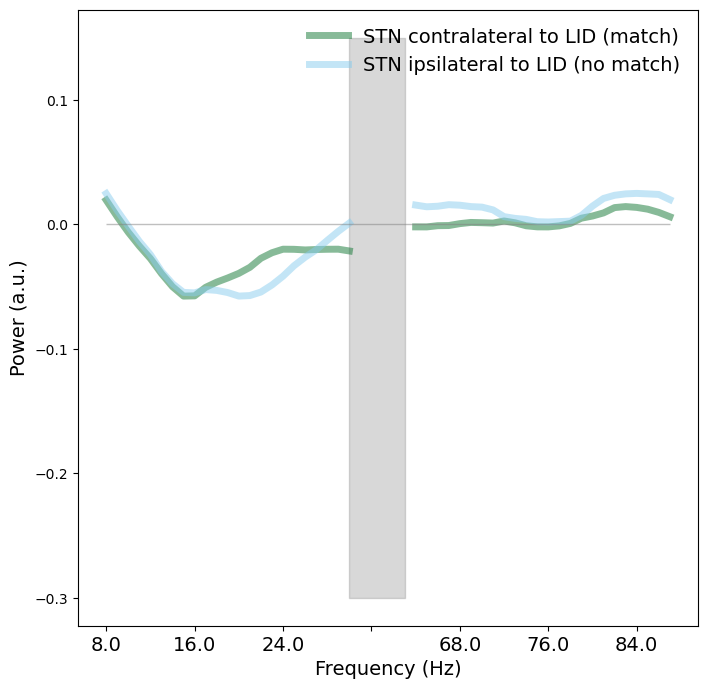

In [483]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

fsize=14

ax = plot_PSD_vs_LID_laterality(
    TFs, sel_subs=subs_LID,
    LOG_POWER=False,
    SMOOTH_PLOT_FREQS=SMOOTH_FREQS,
    ZSCORE_FREQS=False,
    plt_ax_to_return=ax,
    fsize=fsize,
    BREAK_X_AX=True,
)

plt.show()

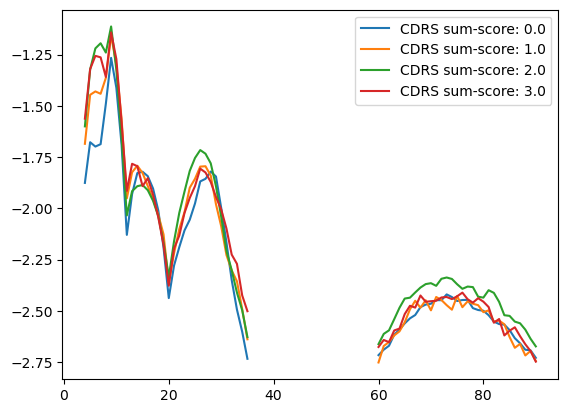

In [298]:
for score in np.unique(ephys_cdrs):
    # blank freqs irrelevant after SSD
    blank_sel = np.logical_and(tf_freqs > 35, tf_freqs < 60)
    tf_values[blank_sel, :] = np.nan

    window_sel = ephys_cdrs == score
    score_psds = tf_values[:, window_sel]

    mean_psd = np.mean(score_psds, axis=1)

    # for code_score, score_label in zip(cdrs_cats.values(),
    #                                    cdrs_cats.keys()):
    #     if code_score == score: cdrs_code = score_label

    plt.plot(tf_freqs, mean_psd,
            #  label=f'CDRS: {cdrs_code}',
             label=f'CDRS sum-score: {score}',
            )

plt.legend()
plt.show()

In [ ]:
# replicate SSD extraction

importlib.reload(ssd)
# loop over windows

for i_w, win_dat in enumerate(windows.data[:5]):
    win_dat = win_dat.astype(np.float64)    
    # select only rows without missing
    nan_rows = np.array([pd.isna(win_dat[:, i]).any()
                for i in range(win_dat.shape[-1])])
    win_dat = win_dat[:, ~nan_rows]
    win_chnames = list(compress(windows.keys, ~nan_rows))
    win_time = windows.win_starttimes[i_w]
    
    ssds = ssd.SSD_bands_per_window(
        data=win_dat.T, s_rate=windows.fs,
        freq_bands_incl=SETTINGS['SPECTRAL_BANDS'],
    )
 



Phase features to add:
- local PAC from De Hempt (ECoG) (beta-phase, gamma-ampl)
    - EEGLAB ASYMM PAC
    - check calculation via entropy of amplitudes per bin
    - or MI-inde
- phase-phase: CHECK CAGNAN BURST WORK
    - connectivity phase differences from Swann et al (phase-coherence) (angle STN versus angle ECoG, compare with imaginary-coherence)

In [ ]:
import lfpecog_plotting.phase_plotting as phaseplot

In [ ]:
importlib.reload(phaseplot)

### phase difference
# plt.figure(figsize=(12, 4))
# get both signals
sig1 = ssds.lo_beta.copy()
sig2 = ssd0.lo_beta.copy()
# convert to analytic signal
a1 = signal.hilbert(x=sig1,)
a2 = signal.hilbert(x=sig2,)
# get phase from analytical signal, convert from pi to degree
rad1 = np.angle(a1)
deg1 = np.rad2deg(rad1)
rad2 = np.angle(a2)
deg2 = np.rad2deg(rad2)
# get difference, convert all to positive degrees (-90 -> +270)
rad_diff = rad1 - rad2
deg_diff = deg1 - deg2
mask_deg = deg_diff < 0  # bool-array, 0 for values >= 0
mask_rad = rad_diff < 0
corr_rad = np.array([2 * np.pi] * len(rad_diff)) * mask_rad  # corr array is set 0 for pos diff-values
rad_diff += corr_rad
corr_deg = np.array([360] * len(deg_diff)) * mask_deg  # corr array is set 0 for pos diff-values
deg_diff += corr_deg
plt.plot(rad_diff, label='corr', alpha=.8, ls='dotted')
plt.xlim(0, 5000)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(sig1)
plt.plot(sig2)
plt.xlim(0, 5000)
plt.show()

phaseplot.plot_rose_axis(radians=rad_diff)

In [ ]:
sig_phase = ssd_014.ecog_right.lo_beta[10].copy()
sig_ampl = ssd_014.ecog_right.broad_gamma[10].copy()
# sig = ssds.lo_beta.copy()

a_phase = signal.hilbert(x=sig_phase,)
a_ampl = signal.hilbert(x=sig_ampl,)
phase = np.angle(a_phase)
phase_deg = np.rad2deg(phase)  #phase * (180 / np.pi)
ampl = abs(a_ampl)
plt.plot(phase)
plt.plot(ampl)
plt.xlim(0, 1000)
plt.yticks([-np.pi, 0, np.pi],
           labels=['-180', '0', '+180'],)
plt.ylabel('Phase (degree)')
plt.xlabel('time (samples)')
plt.show()



### Calculate PAC

In [ ]:
from tensorpac import Pac
import lfpecog_features.feats_phase_amp_coupling as fts_pac
import lfpecog_features.extract_ssd_features as ssdFts


In [ ]:
SETTINGS = utilsFiles.load_ft_ext_cfg(cfg_fname='ftExtr_spectral_v1.json')

In [ ]:
importlib.reload(phase_fts)

pac_values = fts_pac.calculate_PAC_matrix(
    sig_pha=ssd_014.ecog_right.lo_beta,
    sig_amp=ssd_014.ecog_right.narrow_gamma,
    window_times=ssd_014.ecog_right.times,
    fs=ssd_014.ecog_right.fs,
    freq_range_pha=SETTINGS['SPECTRAL_BANDS']['lo_beta'],
    freq_range_amp=SETTINGS['SPECTRAL_BANDS']['narrow_gamma']
)

### Develop phase-difference values

In [ ]:
phase_deg = phase * (180 / np.pi)

phase_bins = {}
for bin_start in np.arange(-180, 180, 20):
    bin_sel = np.logical_and(phase_deg > bin_start,
                             phase_deg<(bin_start+20))
    ampl_sel = ampl[bin_sel]

    phase_bins[bin_start] = ampl_sel

In [ ]:
for bin in phase_bins:
    amps = phase_bins[bin]
    plt.hist(amps,alpha=.3)
    ent = stats.entropy(amps)
    plt.title(f'{bin} degree: entropy {ent}')
    plt.close()

#### fooof for spectral features

for now decided to use knee-models

´fm_knee = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='knee', # fixed or knee
    verbose=False,
)`

fm_knee.fit(f, pxx, [4, 148])

params:
- fm_knee.get_results().error  # error of the fit
- fm_knee.get_results().r_squared  # r^2 (goodness) of fit
- fm_knee.get_results().aperiodic_params  # offset, knee, exponent OR offset, exponent
- fm_knee.get_results().peak_params  # 2d array with pro row one peak's [mid-f, power, bandwidth]
- fm_knee.get_results().gaussian_params  # 2d array with Gaussian fits of peaks [mid-f, height, sd]


In [ ]:
from fooof import FOOOF


fooof_ft_path = os.path.join(
    get_project_path('results'),
    'features',
    'psds',
    'fooofed_psds',
    f'{data_version}_60sWin_50overlap',
    'fooof_per_10sec'
)
if not os.path.exists(fooof_ft_path): os.makedirs(fooof_ft_path)

fooof_fig_dir = os.path.join(fooof_ft_path, 'plot_checks')

In [ ]:

fs = data.info['sfreq']
nperseg = 1024
fooof_range = [4, 98]  # wider window -> more accurate, more comp-time
bw_ranges = {   'alpha': [8, 12],
                'lo_beta': [12, 20],
                'hi_beta': [20, 35],
                'midgamma': [60, 90]}


In [ ]:
# importlib.reload(specHelp)
# importlib.reload(spectral)

# save_csv = True
# plot_examples = False

# n_epochs2merge = 10 / .5  # desired epoch length / current epoch length


# for i_win in np.arange(len(data.list_mne_objects))[4:]:
#     # get spectral power value per window (60-sec)
#     win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
#     chnames = data.list_mne_objects[i_win].ch_names

#     epoch_feats, epoch_feats_lists = {}, {}
#     fits = {}

#     for i_ep in np.arange(0, win_dat.shape[0], int(n_epochs2merge)):
#         # merge epochs
#         tempdat = win_dat[i_ep, :, :]
#         for i2 in np.arange(i_ep + 1, i_ep + n_epochs2merge):
#             try:
#                 tempdat = np.concatenate((tempdat, win_dat[i2, :, :]), axis=1)
#             except IndexError:  # exceeds end of array bcs of blind + 20
#                 pass

#         (
#             epoch_feats[i_ep],
#             epoch_feats_lists[i_ep],
#             fits[i_ep]
#         ) = spectral.get_fooof_fts_per_epoch(
#             epoch_dat=tempdat,
#             ch_names=chnames,
#             fs=fs,
#             nperseg=nperseg,
#             max_n_fooof_peaks=8,
#             fooof_range=fooof_range,
#             i_e=i_ep, fooof_fig_dir=fooof_fig_dir,
#             plot_examples=plot_examples,
#         )

#     all_fits = []
#     for i in fits.keys(): all_fits.extend(fits[i])
        
#     print(f'WIN {i_win}, ALL epochs: mean R2 {round(np.mean(all_fits), 2)} +/- {round(np.std(all_fits), 2)}')

#     fname = f'fooofPowers_{sub}_{task}_win{i_win}.csv'

#     winfeats = spectral.create_windowFrame_specFeats(
#         epoch_feats, save_csv=save_csv,
#         csv_path=fooof_ft_path, csv_fname=fname,
#         fooof_fits=fits,
#     )


In [ ]:
fm = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='knee',
    verbose=False,
    max_n_peaks=5,
)

win_dat = data.list_mne_objects[i_win].get_data()
f, pxx = signal.welch(win_dat[5, 2, :], fs=fs, nperseg=nperseg,)
pxx = specHelp.correct_notch_throughs(f, pxx, np.arange(50, 1201, 50))

fm.report(f, pxx, [4, 98])


#### SSD with meet toolbox (https://github.com/neurophysics/meet)

In [ ]:
import meet.meet as meet

In [ ]:
# get data
i_win = 5
win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
ch_names = data.list_mne_objects[i_win].ch_names
fs = data.info['sfreq']
nperseg = 1024
bw_ranges = {   'alpha': [8, 12],
                'lo_beta': [12, 20],
                'hi_beta': [20, 35],
                'beta': [12, 35],
                'midgamma': [60, 90]}


In [ ]:
from lfpecog_features import feats_SSD as ssd

In [ ]:
# test and plot SSD functionality

importlib.reload(ssd)

SOURCE_SEL = 'ECOG'
F_BAND_SEL = 'midgamma'
epoch_i = 50
plt.close()
# select 2d data of one source (n-channels x n-samples)
ch_sel = [n.startswith(SOURCE_SEL) for n in ch_names]
epoch_dat = win_dat[epoch_i, ch_sel, :]

fig, axes = plt.subplots(3, 1, figsize=(8,8))

for F_BAND_SEL in ['lo_beta', 'hi_beta', 'beta', 'midgamma']:
    ssd_filt_data, ssd_pattern, ssd_eigvals = ssd.get_SSD_component(
        data_2d=epoch_dat,
        fband_interest=bw_ranges[F_BAND_SEL],
        s_rate=fs,
        use_freqBand_filtered=True,
        return_comp_n=0,
    )
    f, psd = signal.welch(ssd_filt_data, axis=-1, nperseg=fs, fs=fs)

    axes[0].plot(ssd_filt_data, label=F_BAND_SEL)
    axes[1].plot(f, psd, label=F_BAND_SEL)

# psd of origin
for i in range(epoch_dat.shape[0]):
    f, psd = signal.welch(epoch_dat[i, :], nperseg=fs, fs=fs)
    axes[2].plot(f, psd, label=F_BAND_SEL, c='k', alpha=.3,)

axes[0].legend(ncol=4)
axes[1].legend()
axes[0].set_title('SSD filtered bands', fontsize=14, weight='bold',)
axes[0].set_ylabel('LFP (a.u.)', fontsize=14,)
axes[0].set_xlabel('Time (samples, 2048 Hz)', fontsize=14,)
axes[1].set_title('Freq-specific PSD after SSD', fontsize=14, weight='bold',)
axes[2].set_title('Original PSDs of channels', fontsize=14, weight='bold',)

for ax in [1, 2]:
    axes[ax].set_xlim(0, 100)
    axes[ax].set_xlabel('Frequency (Hz)', fontsize=14,)
    axes[ax].set_ylabel('Power (a.u.)', fontsize=14,)

for ax in axes: ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()
figname = 'SSD_example_timeseries_PSD'
# plt.savefig(os.path.join(figpath, 'ft_exploration', 'SSD', figname),
#             dpi=300, facecolor='w',)

plt.close()



In [ ]:
# # plot SSD Components
# for i, b in enumerate(SSD_beta):
#     plt.plot(b, label=f'ch {i}',
#              alpha=(1 - (i * .2)),
#              lw=5 - i)
# # beta1d = SSD_beta.T @ np.atleast_2d(SSD_eigvals).T  # combined signal, not relevant
# # plt.plot(beta1d, label='product', c='k')
# plt.legend()
# plt.show()

SSD on 2D arrays to get info about spatial patterns

In [ ]:
# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=multi_arr, fs=fs,
    freqband_to_optim=(14, 18)
)

# spec_ratio, sorter = ssd_obj.get_spectral_ratio(ssd_sources)

In [ ]:
importlib.reload(specHelp)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

xlabels = [1, 5, 10, 25, 50, 75, 100, 200, 400]

freqs_ssd = (16, 20)
longsig = np.ravel(ch_wins[:20:2, :])
sig = np.ravel(ch_wins[18:20, :])

ssd_sig = longsig

f, Px = signal.welch(
    ssd_sig, fs=fs, nperseg=nperseg,
)
f[0] = 1
axes[0].plot(
        np.log(f), np.log(Px),
        alpha=.5, color='k',)
axes[0].set_xticks(np.log(xlabels))
axes[0].set_xticklabels(xlabels)
axes[0].set_xlabel('Log-Freq (Hz)')
axes[0].set_ylabel('Log-Power')
axes[0].set_xlim(0, np.log(50))

axes[0].set_title('Original')

# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=ssd_sig, fs=fs,
    freqband_to_optim=freqs_ssd
)
print(ssd_sources.shape)
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources, sfreq=fs, n_fft=1024)

freqs[0] = 1
axes[1].plot(
    np.log(freqs), np.log(np.ravel(psd)),
    alpha=.5, color='k',)
axes[1].set_xticks(np.log(xlabels))
axes[1].set_xticklabels(xlabels)
axes[1].set_xlabel('Log-Freq (Hz)')
axes[1].set_ylabel('Log-Power')
axes[1].set_xlim(0, np.log(50))

for ax in axes:
    ax.fill_betweenx(
        y=ax.get_ylim(),
        x1=np.log(freqs_ssd[0]), x2=np.log(freqs_ssd[1]),
        color='orange', alpha=.2,)
axes[1].set_title(f'After SSD on {freqs_ssd} Hz')

plt.show()

get fooof running


In [ ]:
from fooof import FOOOF
fm = FOOOF()

# FOOOF peak definition -> MODULE
beta_range = [13, 30]
gamma_range = [60, 90]
fm = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='fixed',
    verbose=False,
)
f_range = [3, 90]
fm.fit(fx, psd, f_range)
beta_f, beta_P, beta_w = get_band_peak_fm(fm, beta_range, select_highest=True)
gamma_f, gamma_P, gamma_w = get_band_peak_fm(fm, gamma_range, select_highest=True)
print(f'Peak frequencies:\nBeta ({beta_range} Hz) peak: '
    f'{np.round(beta_f, 1)} Hz\nGamma ({gamma_range}) peak: '
    f'{np.round(gamma_f, 1)} Hz')
# fm.plot()
# creating bandwidth around Gamma-peak
gamma_frange_psd = [
    np.argmin(abs(fx - (gamma_f - 5))),
    np.argmin(abs(fx - gamma_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (gamma_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
gamma_peak_height = logpsd[gamma_frange_psd[1]] - np.mean([
    logpsd[gamma_frange_psd[0]], logpsd[gamma_frange_psd[2]]
])
# creating bandwidth around Beta-peak
beta_frange_psd = [
    np.argmin(abs(fx - (beta_f - 5))),
    np.argmin(abs(fx - beta_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (beta_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
beta_peak_height = logpsd[beta_frange_psd[1]] - np.mean([
    logpsd[beta_frange_psd[0]], logpsd[beta_frange_psd[2]]
])
print(f'Local peak heights:\nBeta: {beta_peak_height},\n'
    f'Gamma: {gamma_peak_height}')

### PLOTTING
fig, ax  = plt.subplots(1,1, figsize=(4, 4))
ax.plot(fx, logpsd)
ax.set_xlim(60, 95)

ax.scatter(
    fx[gamma_frange_psd],
    logpsd[gamma_frange_psd]
)

plt.show()
## take psd plots from before
## 4d polynominal fit for gamma peak detect (also beta peak)
## beta-gamma power around peak
## coherence

### Explore spectral domain: Try out wavelet

In [ ]:
def wavelet_log(time, Fs, sig):
    '''
    Morlet Wavelet and returns
    logged values
    Input:
        - time: array with timesamples
        - Fs: sample freq
        - sig: 1d array of time series of interest
    Returns:
        - time: unchanged time
        - freqs: arr of freq bins
        - logpsd: calculated log-psd
    '''
    assert len(time) == len(sig), print(
        '\nERROR: Length of time and signal-array'
        ' for wavelet do not match\n###'
    )
    w = 8  # define number of depth/spaces
    freqs = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * freqs * np.pi)
    coefs = signal.cwt(  # wavelet coeff's
        sig, signal.morlet2, widths=widts,
        w=w, dtype='complex128')
    psd = np.abs(coefs)
    logpsd = np.log10(psd)

    return time, freqs, logpsd
    